# IMU Data Preprocessing

## Imports

In [1]:
import numpy as np
import pandas as pd
import csv
import control
import matplotlib.pyplot as plt
from os import path
from io import StringIO
import math

# Quaternions to Euler Angles

In [2]:
def ToEulerAngles(Quaternion):
    
    q = Quaternion
    
    # roll (x-axis rotation)
    sinr_cosp = 2 * (q[0]*q[1]+q[2]*q[3])
    cosr_cosp = 1 - 2 * (q[1]**2+q[2]**2)
    phi = math.atan2(sinr_cosp,cosr_cosp)
    
    # pitch (y-axis rotation)
    sinp = 2 * (q[0]*q[2]-q[3]*q[1])
    theta = np.arcsin(sinp)
    
    # yaw (z-axis rotation)
    siny_cosp = 2 * (q[0]*q[3]+q[1]*q[2])
    cosy_cosp = 1 - 2 * (q[2]**2+q[3]**2)
    psi = math.atan2(siny_cosp,cosy_cosp)
    
    return [phi, theta, psi]

## Read and Convert to DataFrame

In [3]:
def IMU_read(file, *nrows):
    
    with open(f'../data/{file}.csv', 'r') as f:
        contents = f.read()
        f.seek(0,0)
        delimiter = f.readline().strip('\n')
    contentsList = contents.split(delimiter)
    
    if not nrows:
        IMU = pd.read_csv(StringIO(contentsList[3])) 
    else:
        IMU = pd.read_csv(StringIO(contentsList[3]), nrows=nrows)
        
    info = pd.read_csv(StringIO(contentsList[2]), sep=':')
    dt = 1 / float(info.loc['Average sample rate', 'Additional Info'].strip('Hz'))
    
    # Delete last empty column
    if ' ' in IMU.columns:
        del IMU[' ']

    # remove extra space
    IMU.columns = IMU.columns.str.strip()
    
    #
    Quaternions = ['ANGULAR_POSITION_w', 'ANGULAR_POSITION_x', 'ANGULAR_POSITION_y', 'ANGULAR_POSITION_z']
    Quaternions_Cal = ['ANGULAR_POSITION_w_cal', 'ANGULAR_POSITION_x_cal', 'ANGULAR_POSITION_y_cal', 'ANGULAR_POSITION_z_cal']    
    EulerAngles = ['EulerAngle_x', 'EulerAngle_y', 'EulerAngle_z']
    
    # calibrate quarternions
    cal_period = 1
    initial_q = list(np.mean(IMU[Quaternions][:int(cal_period/dt)]))
    negative_initial_q = [initial_q[0],-initial_q[1],-initial_q[2],-initial_q[3]]
    
    # Quaternions Multiplication
    def Multi(p, q=negative_initial_q):
        output = [p[0]*q[0]-p[1]*q[1]-p[2]*q[2]-p[3]*q[3], 
                  p[1]*q[0]+p[0]*q[1]-p[3]*q[2]+p[2]*q[3],
                  p[2]*q[0]+p[3]*q[1]+p[0]*q[2]-p[1]*q[3],
                  p[3]*q[0]-p[2]*q[1]+p[1]*q[2]+p[0]*q[3]]
        return output

    for n, col in enumerate(Quaternions_Cal):
        IMU[col] = IMU[Quaternions].apply(Multi, axis=1).apply(lambda item: item[n])
    
    # adding Euler angles
    new_col_list = EulerAngles
    for n, col in enumerate(new_col_list):
        IMU[col] = IMU[Quaternions_Cal].apply(ToEulerAngles, axis=1).apply(lambda item: item[n])  
        
    return IMU, info, dt

## Save the Desired Columns

In [4]:
def IMU_write(file, sep=',', index=False, accelerations=['LIN_ACC_NO_GRAVITY_x', 'LIN_ACC_NO_GRAVITY_y', 'LIN_ACC_NO_GRAVITY_z'],
             angularpositions=['EulerAngle_x', 'EulerAngle_y', 'EulerAngle_z']):
    
    Acceleration = IMU[accelerations]
    AngularPosition = IMU[angularpositions]
    
#     if not path.exists(f'../data/{file}_Acceleration.csv'):
#         Acceleration.to_csv(f'../data/{file}_Acceleration.csv', sep=sep, index=index)
#         AngularPosition.to_csv(f'../data/{file}_AngularPosition.csv', sep=sep, index=index)
    
    return Acceleration, AngularPosition

## Noise Filter

In [128]:
pi = 3.14

def IMU_filter(Acceleration, AngularPosition, w_c=2*pi):
    
    g = -9.81
    BF = [None] * 3
    
    num_BF = [np.array([(w_c)**3]), 
               np.array([(w_c)**3]), 
               np.array([(w_c)**3])]

    den_BF = [np.array([1, 2*w_c, 2*(w_c)**2, (w_c)**3]), 
               np.array([1, 2*w_c, 2*(w_c)**2, (w_c)**3]), 
               np.array([1, 2*w_c, 2*(w_c)**2, (w_c)**3])]

    BF = [control.tf(num_BF[i], den_BF[i]) for i in range(3)]

    Acceleration_orig = [Acceleration.iloc[:,0].to_numpy(), Acceleration.iloc[:,1].to_numpy(), (Acceleration.iloc[:,2]-g).to_numpy()]
    AngularPosition_orig = [AngularPosition.iloc[:,0].to_numpy(), AngularPosition.iloc[:,1].to_numpy(), AngularPosition.iloc[:,2].to_numpy()]

    T = np.array(range(int(Acceleration.shape[0]))) * dt
    X0 = [0] * 3
    
    _, Acceleration_filtered = zip(*[control.forced_response(BF[i], T=T, U=Acceleration_orig[i], X0=X0[i]) for i in range(3)])
    _, AngularPosition_filtered = zip(*[control.forced_response(BF[i], T=T, U=AngularPosition_orig[i], X0=X0[i]) for i in range(3)])
    Acceleration_filtered = list(Acceleration_filtered)
    Acceleration_filtered[2] = Acceleration_filtered[2] + g
    
    return pd.DataFrame(np.array(Acceleration_filtered).T, columns=Acceleration.columns), pd.DataFrame(np.array(AngularPosition_filtered).T, columns=AngularPosition.columns)

## Calibration

In [111]:
def Calibration(Acceleration, AngularPosition, cal_period):
    
    g = -9.81
    
    Acceleration_calibrated = Acceleration[:]
    Acceleration_calibrated = Acceleration - np.mean(Acceleration[:int(cal_period/dt)])
    Acceleration_calibrated['LIN_ACC_NO_GRAVITY_z'] = Acceleration_calibrated['LIN_ACC_NO_GRAVITY_z'] + g
    
    AngularPosition_calibrated = AngularPosition[:]
    AngularPosition_calibrated = AngularPosition - np.mean(AngularPosition[:int(cal_period/dt)])
    
    return Acceleration_calibrated, AngularPosition_calibrated

In [112]:
# def Quaternions_Calibration(Quaternions, cal_period):

#     Quaternions_calibrated = Quaternions[:]
#     initial_q = list(np.mean(Quaternions[:int(cal_period/dt)]))
#     negative_initial_q = [initial_q[0],-initial_q[1],-initial_q[2],-initial_q[3]]
#     Quaternions_calibrated = Multi(initial_q, negative_initial_q)
    
#     return Quaternions_calibrated

In [113]:
# Quaternions_Cal = ['ANGULAR_POSITION_w_cal', 'ANGULAR_POSITION_x_cal', 'ANGULAR_POSITION_y_cal', 'ANGULAR_POSITION_z_cal']    
# initial_q = list(np.mean(IMU[Quaternions][:int(1/dt)]))
# negative_initial_q = [initial_q[0],-initial_q[1],-initial_q[2],-initial_q[3]]
# Quaternions_calibrated = Multi(initial_q, negative_initial_q)
# Multi(initial_q, negative_initial_q)

# IMU[Quaternions].apply(Multi, axis=1)

## Plot

In [7]:
def IMU_plot(Acceleration, AngularPosition,
             accelerations=['LIN_ACC_NO_GRAVITY_x', 'LIN_ACC_NO_GRAVITY_y', 'LIN_ACC_NO_GRAVITY_z'],
             angularpositions=['EulerAngle_x', 'EulerAngle_y', 'EulerAngle_z']):
    
    T = np.array(range(Acceleration.shape[0])) * dt
    
    fig, ax = plt.subplots(2, 3, figsize=(15,8))
    ax[0, 0].plot(T, Acceleration[accelerations[1]])
    ax[0, 0].set_title('Surge Acceleration')
#     ax[0, 0].set_ylim([Acceleration.min()[0]-0.1*np.abs(Acceleration.min()[0]),Acceleration.max()[0]+0.1*np.abs(Acceleration.max()[0])])
    ax[0, 1].plot(T, Acceleration[accelerations[0]])
    ax[0, 1].set_title('Sway Acceleration')
#     ax[0, 1].set_ylim([Acceleration.min()[1]-0.1*np.abs(Acceleration.min()[1]),Acceleration.max()[1]+0.1*np.abs(Acceleration.max()[1])])
    ax[0, 2].plot(T, Acceleration[accelerations[2]])
    ax[0, 2].set_title('Heave Acceleration')
#     ax[0, 2].set_ylim([Acceleration.min()[2]-0.1*np.abs(Acceleration.min()[2]),Acceleration.max()[2]+0.1*np.abs(Acceleration.max()[2])])
    ax[1, 0].plot(T, AngularPosition[angularpositions[1]])
    ax[1, 0].set_title('Roll Rotation')
#     ax[1, 0].set_ylim([AngularPosition.min()[0]-0.1*np.abs(AngularPosition.min()[0]),AngularPosition.max()[0]+0.1*np.abs(AngularPosition.max()[0])])
    ax[1, 1].plot(T, AngularPosition[angularpositions[0]])
    ax[1, 1].set_title('Pitch Rotation')
#     ax[1, 1].set_ylim([AngularPosition.min()[1]-0.1*np.abs(AngularPosition.min()[1]),AngularPosition.max()[1]+0.1*np.abs(AngularPosition.max()[1])])
    ax[1, 2].plot(T, AngularPosition[angularpositions[2]])
    ax[1, 2].set_title('Yaw Rotation')
#     ax[1, 2].set_ylim([AngularPosition.min()[2]-0.1*np.abs(AngularPosition.min()[2]),AngularPosition.max()[2]+0.1*np.abs(AngularPosition.max()[2])])
    
    ax[0, 0].set_ylim([-0.05+min(Acceleration['LIN_ACC_NO_GRAVITY_y']),0.05+max(Acceleration['LIN_ACC_NO_GRAVITY_y'])])
    ax[0, 1].set_ylim([-0.05+min(Acceleration['LIN_ACC_NO_GRAVITY_x']),0.05+max(Acceleration['LIN_ACC_NO_GRAVITY_x'])])
    ax[0, 2].set_ylim([-0.05+min(Acceleration['LIN_ACC_NO_GRAVITY_z']),0.05+max(Acceleration['LIN_ACC_NO_GRAVITY_z'])])
    ax[1, 0].set_ylim([-0.05+min(AngularPosition['EulerAngle_y']),0.05+max(AngularPosition['EulerAngle_y'])])
    ax[1, 1].set_ylim([-0.05+min(AngularPosition['EulerAngle_x']),0.05+max(AngularPosition['EulerAngle_x'])])
    ax[1, 2].set_ylim([-0.05+min(AngularPosition['EulerAngle_z']),0.05+max(AngularPosition['EulerAngle_z'])])
        
    plt.show()

In [8]:
def Quaternion_plot(IMU,
             angularpositions=['ANGULAR_POSITION_w', 'ANGULAR_POSITION_x', 'ANGULAR_POSITION_y', 'ANGULAR_POSITION_z'],
             angularpositions_cal=['ANGULAR_POSITION_w_cal', 'ANGULAR_POSITION_x_cal', 'ANGULAR_POSITION_y_cal', 'ANGULAR_POSITION_z_cal']):
    
    T = np.array(range(IMU.shape[0])) * dt
    
    fig, ax = plt.subplots(2, 4, figsize=(15,8))
    ax[0, 0].plot(T, IMU[angularpositions[0]])
    ax[0, 0].set_title('ANGULAR_POSITION_w')
#     ax[0, 0].set_ylim([Acceleration.min()[0]-0.1*np.abs(Acceleration.min()[0]),Acceleration.max()[0]+0.1*np.abs(Acceleration.max()[0])])
    ax[0, 1].plot(T, IMU[angularpositions[1]])
    ax[0, 1].set_title('ANGULAR_POSITION_x')
#     ax[0, 1].set_ylim([Acceleration.min()[1]-0.1*np.abs(Acceleration.min()[1]),Acceleration.max()[1]+0.1*np.abs(Acceleration.max()[1])])
    ax[0, 2].plot(T, IMU[angularpositions[2]])
    ax[0, 2].set_title('ANGULAR_POSITION_y')
#     ax[0, 2].set_ylim([Acceleration.min()[2]-0.1*np.abs(Acceleration.min()[2]),Acceleration.max()[2]+0.1*np.abs(Acceleration.max()[2])])
    ax[0, 3].plot(T, IMU[angularpositions[3]])
    ax[0, 3].set_title('ANGULAR_POSITION_z')
#     ax[1, 0].set_ylim([AngularPosition.min()[0]-0.1*np.abs(AngularPosition.min()[0]),AngularPosition.max()[0]+0.1*np.abs(AngularPosition.max()[0])])
    ax[1, 0].plot(T, IMU[angularpositions_cal[0]])
    ax[1, 0].set_title('ANGULAR_POSITION_w_cal')
#     ax[0, 0].set_ylim([Acceleration.min()[0]-0.1*np.abs(Acceleration.min()[0]),Acceleration.max()[0]+0.1*np.abs(Acceleration.max()[0])])
    ax[1, 1].plot(T, IMU[angularpositions_cal[1]])
    ax[1, 1].set_title('ANGULAR_POSITION_x_cal')
#     ax[0, 1].set_ylim([Acceleration.min()[1]-0.1*np.abs(Acceleration.min()[1]),Acceleration.max()[1]+0.1*np.abs(Acceleration.max()[1])])
    ax[1, 2].plot(T, IMU[angularpositions_cal[2]])
    ax[1, 2].set_title('ANGULAR_POSITION_y_cal')
#     ax[0, 2].set_ylim([Acceleration.min()[2]-0.1*np.abs(Acceleration.min()[2]),Acceleration.max()[2]+0.1*np.abs(Acceleration.max()[2])])
    ax[1, 3].plot(T, IMU[angularpositions_cal[3]])
    ax[1, 3].set_title('ANGULAR_POSITION_z_cal')
#     ax[1, 0].set_ylim([AngularPosition.min()[0]-0.1*np.abs(AngularPosition.min()[0]),AngularPosition.max()[0]+0.1*np.abs(AngularPosition.max()[0])])

    ax[0, 0].set_ylim([-0.05+min(IMU['ANGULAR_POSITION_w']),0.05+max(IMU['ANGULAR_POSITION_w'])])
    ax[0, 1].set_ylim([-0.05+min(IMU['ANGULAR_POSITION_x']),0.05+max(IMU['ANGULAR_POSITION_x'])])
    ax[0, 2].set_ylim([-0.05+min(IMU['ANGULAR_POSITION_y']),0.05+max(IMU['ANGULAR_POSITION_y'])])
    ax[0, 3].set_ylim([-0.05+min(IMU['ANGULAR_POSITION_z']),0.05+max(IMU['ANGULAR_POSITION_z'])])
    ax[1, 0].set_ylim([-0.05+min(IMU['ANGULAR_POSITION_w_cal']),0.05+max(IMU['ANGULAR_POSITION_w_cal'])])
    ax[1, 1].set_ylim([-0.05+min(IMU['ANGULAR_POSITION_x_cal']),0.05+max(IMU['ANGULAR_POSITION_x_cal'])])
    ax[1, 2].set_ylim([-0.05+min(IMU['ANGULAR_POSITION_y_cal']),0.05+max(IMU['ANGULAR_POSITION_y_cal'])])
    ax[1, 3].set_ylim([-0.05+min(IMU['ANGULAR_POSITION_z_cal']),0.05+max(IMU['ANGULAR_POSITION_z_cal'])])
    
    plt.show()

## Read and Convert to DataFrame

In [9]:
import ipywidgets as widgets

data = widgets.Dropdown(
    options=['-', 'Semitruck', 'TruckStarting', 'PickupDonuts', 'PickupLazyEight'],
    value='-',
    description='IMU Data:',
    disabled=False,
)
data

Dropdown(description='IMU Data:', options=('-', 'Semitruck', 'TruckStarting', 'PickupDonuts', 'PickupLazyEight…

In [10]:
if data.value != '-':
    file = data.value
else:
    raise Exception("Sorry, you have to pick an IMU Data!")

Exception: Sorry, you have to pick an IMU Data!

In [ ]:
IMU, info, dt = IMU_read(file, dt)
# IMU, info, dt = IMU_read(file, dt, nrows=25000)

# UMB

In [544]:
file = 'SwayPeriodicLaneChange'

In [545]:
IMU, info, dt = IMU_read(file + 'Combined')

In [546]:
info

,Additional Info
Time elapsed,34.9131319 seconds
First sample id,1884841
Last sample id,1889214
Total packets,4373 packets
Dropped packets,0 packets
Time of first lost packet,0
Average sample rate,125.2537301014808 Hz


In [547]:
if len(np.where(IMU.dtypes == 'object')[0]) == 0:
    print(f'There exist {len(np.where(IMU.isnull().sum() != 0)[0])} columns with missing Values...')
    for i in range(len(np.where(IMU.isnull().sum() != 0)[0])):
        print(f'{IMU.columns[np.where(IMU.isnull().sum() != 0)[0][i]]} has {IMU.isnull().sum().iloc[np.where(IMU.isnull().sum() != 0)[0][i]]} missing values!')
else:
    obj_num = len(np.where(IMU.dtypes == 'object')[0])
    print(f'There exist {obj_num} columns with non-integer/non-float values. Please fix them first!')

There exist 0 columns with missing Values...


In [548]:
IMU

,Timestamp (us),SAMPLE_ID,MOUSE_x,MOUSE_y,LINEAR_ACCELERATION_x,LINEAR_ACCELERATION_y,LINEAR_ACCELERATION_z,LIN_ACC_NO_GRAVITY_x,LIN_ACC_NO_GRAVITY_y,LIN_ACC_NO_GRAVITY_z,...,ANGULAR_POSITION_x,ANGULAR_POSITION_y,ANGULAR_POSITION_z,ANGULAR_POSITION_w_cal,ANGULAR_POSITION_x_cal,ANGULAR_POSITION_y_cal,ANGULAR_POSITION_z_cal,EulerAngle_x,EulerAngle_y,EulerAngle_z
0,0,1884841,0,0,-0.554688,-0.442383,-9.852539,-0.012695,0.002930,0.044922,...,-0.021484,0.028076,0.036133,0.999954,0.000037,-0.000107,-0.000050,0.000074,-0.000215,-0.000099
1,7999,1884842,0,0,-0.533203,-0.447266,-9.913086,0.008789,-0.001953,-0.016602,...,-0.021484,0.028076,0.036133,0.999954,0.000037,-0.000107,-0.000050,0.000074,-0.000215,-0.000099
2,15998,1884843,0,0,-0.539062,-0.427734,-9.933594,0.002930,0.017578,-0.037109,...,-0.021484,0.028076,0.036133,0.999954,0.000037,-0.000107,-0.000050,0.000074,-0.000215,-0.000099
3,24015,1884844,0,0,-0.552734,-0.465820,-9.870117,-0.010742,-0.019531,0.026367,...,-0.021484,0.028076,0.036133,0.999954,0.000037,-0.000107,-0.000050,0.000074,-0.000215,-0.000099
4,32054,1884845,0,0,-0.529297,-0.438477,-9.875000,0.012695,0.006836,0.021484,...,-0.021484,0.028076,0.036133,0.999893,0.000036,-0.000106,-0.000047,0.000072,-0.000211,-0.000095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4369,34878066,1889210,0,0,-0.801758,-0.154297,-9.666992,-0.184570,0.301758,0.231445,...,-0.022034,0.031799,0.030823,0.999878,-0.000796,0.003477,-0.005417,-0.001629,0.006944,-0.010839
4370,34886026,1889211,0,0,-1.167969,-0.222656,-10.228516,-0.545898,0.232422,-0.330078,...,-0.021973,0.031982,0.030884,0.999884,-0.000740,0.003663,-0.005362,-0.001519,0.007317,-0.010728
4371,34894036,1889212,0,0,-1.717773,-0.109375,-9.685547,-1.091797,0.344727,0.212891,...,-0.021912,0.032227,0.030945,0.999892,-0.000686,0.003910,-0.005308,-0.001413,0.007813,-0.010621
4372,34902062,1889213,0,0,-2.249023,-0.178711,-10.109375,-1.619141,0.273438,-0.210938,...,-0.021790,0.032471,0.031006,0.999899,-0.000571,0.004160,-0.005256,-0.001186,0.008313,-0.010516


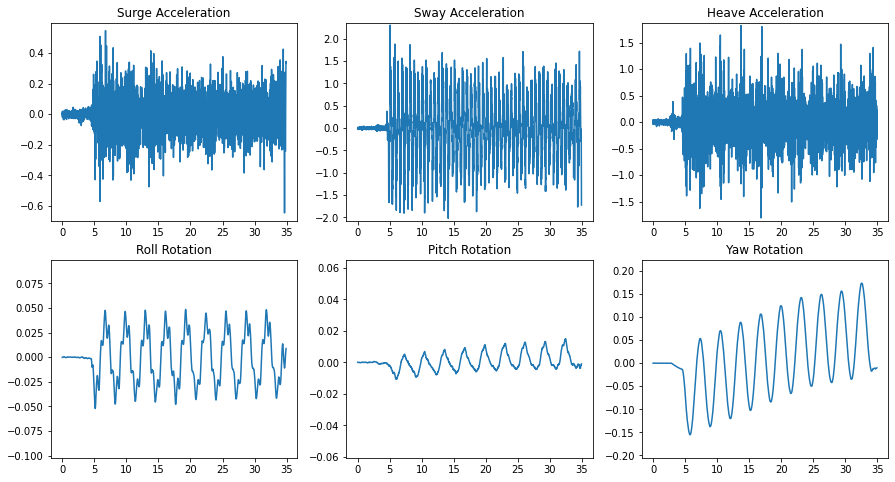

In [549]:
Acceleration, AngularPosition = IMU_write(file)
IMU_plot(Acceleration=Acceleration, AngularPosition=AngularPosition)

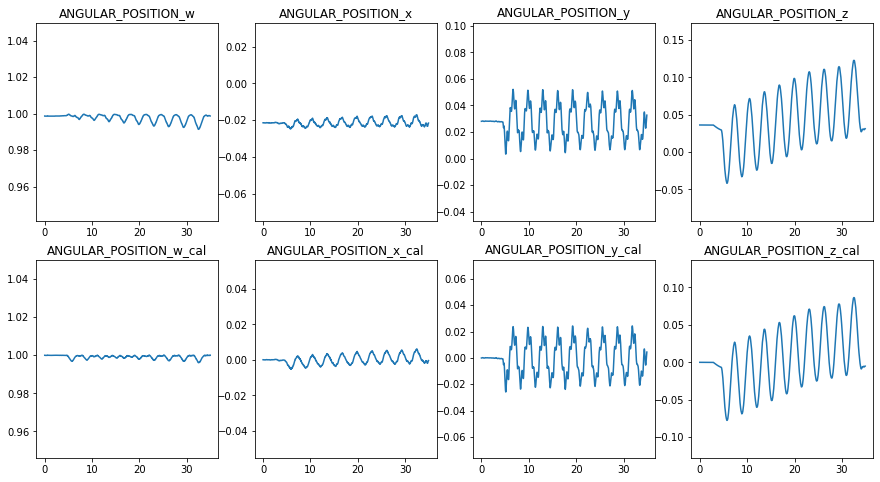

In [550]:
Quaternion_plot(IMU=IMU)

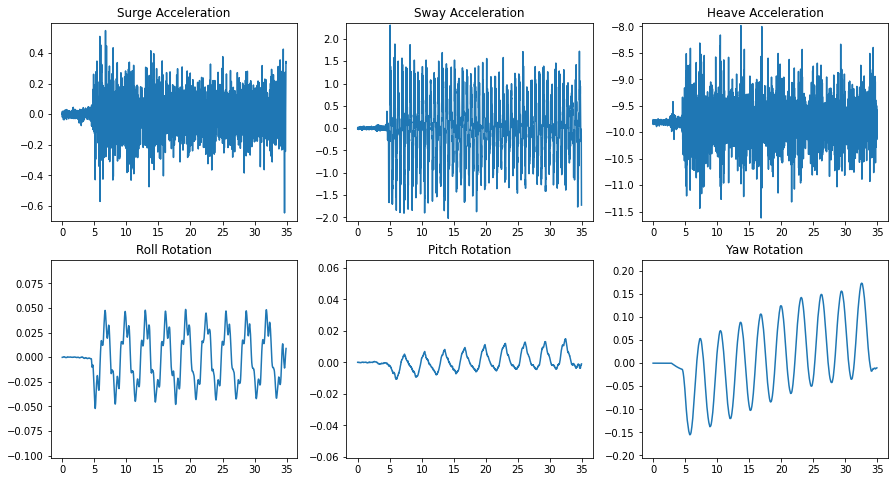

In [551]:
Acceleration_calibrated, AngularPosition_calibrated = Calibration(Acceleration=Acceleration, AngularPosition=AngularPosition, cal_period=1)
IMU_plot(Acceleration=Acceleration_calibrated, AngularPosition=AngularPosition_calibrated)

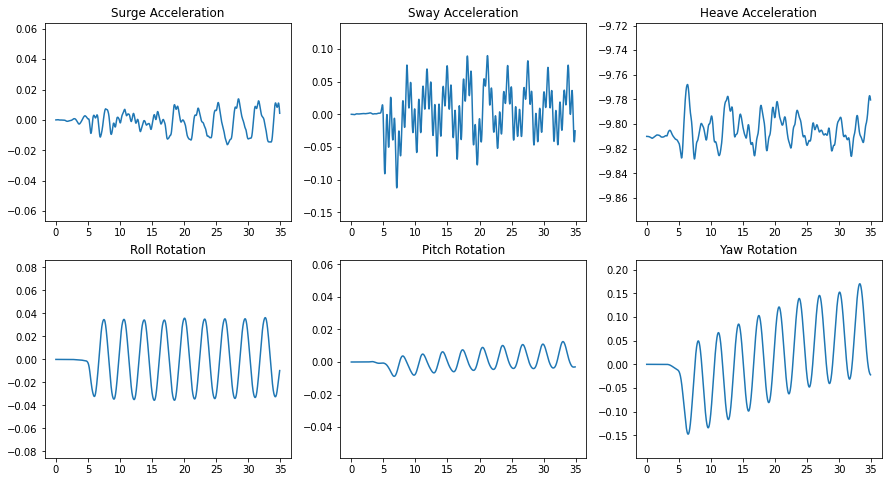

In [552]:
Acceleration_filtered, AngularPosition_filtered = IMU_filter(Acceleration=Acceleration_calibrated, AngularPosition=AngularPosition_calibrated, w_c=1*pi)
IMU_plot(Acceleration=Acceleration_filtered, AngularPosition=AngularPosition_filtered)

In [281]:
Quaternions = ['ANGULAR_POSITION_w', 'ANGULAR_POSITION_x', 'ANGULAR_POSITION_y', 'ANGULAR_POSITION_z']
initial_q = list(np.mean(IMU[Quaternions][:int(1/dt)]))
initial_q

[0.98150634765625, -0.02107958984375, 0.020658203125, -0.18904833984375]

In [282]:
EA = ToEulerAngles(initial_q)
EA = [-EA[0], -EA[1], -EA[2]]
EA

[0.04923632531593159, -0.032587959695079584, 0.3813499332305231]

In [283]:
def mat_vec(A, y):
    return np.array([np.dot(A, y[i]) for i in range(y.shape[0]-1)]).T

def RA(y, beta_s_BF):

    phi, theta, psi = beta_s_BF

    y_new = y.copy()

    RA = np.array([[1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
          [0, np.cos(phi), -np.sin(phi)],
          [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])

    y_new = mat_vec(RA, y)
    return y_new

In [284]:
ACC = Acceleration_filtered.to_numpy()

In [285]:
RA(ACC, EA)

array([[ 0.31941354,  0.31941352,  0.31941349, ...,  0.31991276,
         0.31996026,  0.32000799],
       [ 0.48281322,  0.48281313,  0.48281262, ...,  0.48329086,
         0.48331543,  0.48332888],
       [-9.8033166 , -9.80331662, -9.80331654, ..., -9.80434606,
        -9.804358  , -9.80437015]])

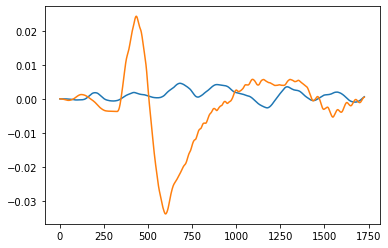

In [286]:
plt.plot(ACC[:,0])
plt.plot(ACC[:,1])

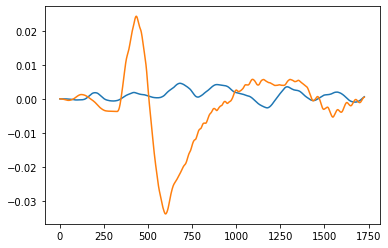

In [287]:
plt.plot(Acceleration_filtered.to_numpy()[:,0])
plt.plot(Acceleration_filtered.to_numpy()[:,1])

# Comparison

In [449]:
file = 'SurgePeriodic'
case = '_2'

In [450]:
file_DBox = file + 'DBox' + case
IMU, info_DBox, dt_DBox = IMU_read(file_DBox)
Acceleration_DBox, AngularPosition_DBox = IMU_write(file_DBox)
Acceleration_calibrated_DBox, AngularPosition_calibrated_DBox = Calibration(Acceleration=Acceleration_DBox, AngularPosition=AngularPosition_DBox, cal_period=1)
Acceleration_filtered_DBox, AngularPosition_filtered_DBox = IMU_filter(Acceleration=Acceleration_calibrated_DBox, AngularPosition=AngularPosition_calibrated_DBox, w_c=1*pi)
# IMU_plot(Acceleration=Acceleration_filtered_DBox, AngularPosition=AngularPosition_filtered_DBox)

file_Teknic = file + 'Teknic' + case
IMU, info_Teknic, dt_Teknic = IMU_read(file_Teknic)
Acceleration_Teknic, AngularPosition_Teknic = IMU_write(file_Teknic)
Acceleration_calibrated_Teknic, AngularPosition_calibrated_Teknic = Calibration(Acceleration=Acceleration_Teknic, AngularPosition=AngularPosition_Teknic, cal_period=1)
Acceleration_filtered_Teknic, AngularPosition_filtered_Teknic = IMU_filter(Acceleration=Acceleration_calibrated_Teknic, AngularPosition=AngularPosition_calibrated_Teknic, w_c=1*pi)
# IMU_plot(Acceleration=Acceleration_filtered_Teknic, AngularPosition=AngularPosition_filtered_Teknic)

file_Combined = file + 'Combined' + case
IMU, info_Combined, dt_Combined = IMU_read(file_Combined)
Acceleration_Combined, AngularPosition_Combined = IMU_write(file_Combined)
Acceleration_calibrated_Combined, AngularPosition_calibrated_Combined = Calibration(Acceleration=Acceleration_Combined, AngularPosition=AngularPosition_Combined, cal_period=1)
Acceleration_filtered_Combined, AngularPosition_filtered_Combined = IMU_filter(Acceleration=Acceleration_calibrated_Combined, AngularPosition=AngularPosition_calibrated_Combined, w_c=1*pi)
# IMU_plot(Acceleration=Acceleration_filtered_Combined, AngularPosition=AngularPosition_filtered_Combined)


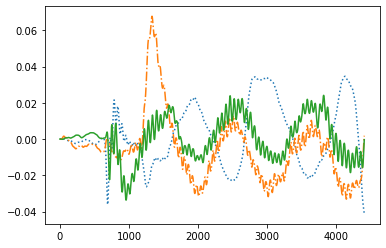

In [451]:
L = min(Acceleration_filtered_DBox.shape[0], Acceleration_filtered_Teknic.shape[0])
plt.plot(Acceleration_filtered_DBox.to_numpy()[:L,1], ':')
plt.plot(Acceleration_filtered_Teknic.to_numpy()[:L,1], '-.')
# plt.plot(Acceleration_filtered_DBox.to_numpy()[:L,1]+Acceleration_filtered_Teknic.to_numpy()[:L,1])
plt.plot(Acceleration_filtered_Combined.to_numpy()[:L,1])

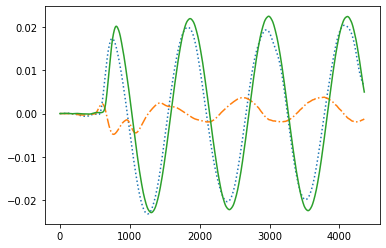

In [448]:
L = min(AngularPosition_filtered_DBox.shape[0], AngularPosition_filtered_Teknic.shape[0])
plt.plot(AngularPosition_filtered_DBox.to_numpy()[:L,0], ':')
plt.plot(AngularPosition_filtered_Teknic.to_numpy()[:L,0], '-.')
# plt.plot(Acceleration_filtered_DBox.to_numpy()[:L,0]+Acceleration_filtered_Teknic.to_numpy()[:L,0])
plt.plot(AngularPosition_filtered_Combined.to_numpy()[:L,0])